## Lyft Challenge!

https://www.udacity.com/lyft-challenge

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import pdb
from pathlib import Path

In [4]:
PATH = Path('data/lyft')
list(PATH.iterdir())

[PosixPath('data/lyft/train_masks'),
 PosixPath('data/lyft/train'),
 PosixPath('data/lyft/car_masks'),
 PosixPath('data/lyft/models'),
 PosixPath('data/lyft/tmp'),
 PosixPath('data/lyft/new')]

In [5]:
VEHICLES = 10 # Data encoding in the segmented image
ROADS = 7
ROAD_LINES = 6

def isolate_cars(filename):
    img = Image.open(filename)

    img_np = np.array(img)

    img_np_R = img_np[:,:,0] # Pull out R channel

    img_np_R[img_np_R == VEHICLES] = 255    

    img_np_R[img_np_R != 255] = 0
    
    h,w = img_np_R.shape
    img_np_R[int(.82*h):h, :] = 0 # Set hood to zero

    new_img = np.stack((img_np_R,img_np_R,img_np_R), axis=-1)
    
    image = Image.fromarray(new_img, 'RGB')
    dest = Path('data/lyft/car_masks')
    image.save(dest/filename.name)

In [6]:
def show_img(im, figsize=(8,8), ax=None, alpha=None):
    if not ax: fix, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

The following code takes the original labelled images and converts them to a more usable format. **Run this next cell only once.**

In [9]:
# seg_PATH = Path('train/CameraSeg') # Old data
seg_PATH = Path('data/lyft/new/CameraSeg') # New data
original_segs = list(seg_PATH.iterdir())

for file in original_segs:
    isolate_cars(file)

In [10]:
input_images = PATH/'train'
output_images = PATH/'car_masks'

list(input_images.iterdir())[:3]

[PosixPath('data/lyft/train/5.png'),
 PosixPath('data/lyft/train/88.png'),
 PosixPath('data/lyft/train/F68-87.png')]

In [11]:
list(output_images.iterdir())[:3]

[PosixPath('data/lyft/car_masks/5.png'),
 PosixPath('data/lyft/car_masks/88.png'),
 PosixPath('data/lyft/car_masks/F68-87.png')]

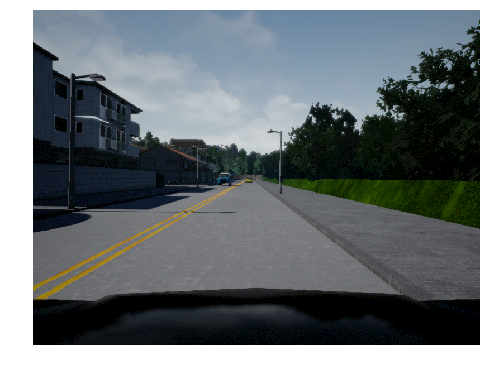

In [12]:
real_world = open_image(list(input_images.iterdir())[0])
show_img(real_world)

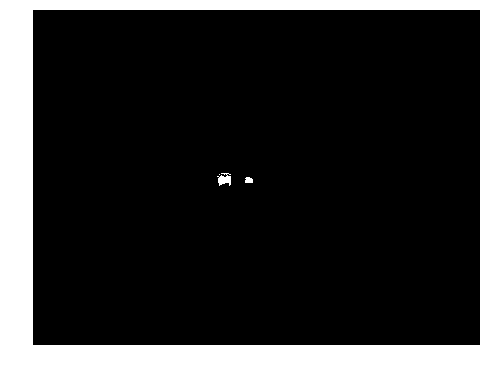

In [13]:
test_seg_image = open_image(list(output_images.iterdir())[0])
show_img(test_seg_image)

## Visualize data

In [14]:
TRAIN_DN = 'train'
MASKS_DN = 'car_masks'
sz = 128
bs = 64

In [15]:
ims = [open_image(list(input_images.iterdir())[i]) for i in range(16)]
masks = [open_image(list(output_images.iterdir())[i]) for i in range(16)]

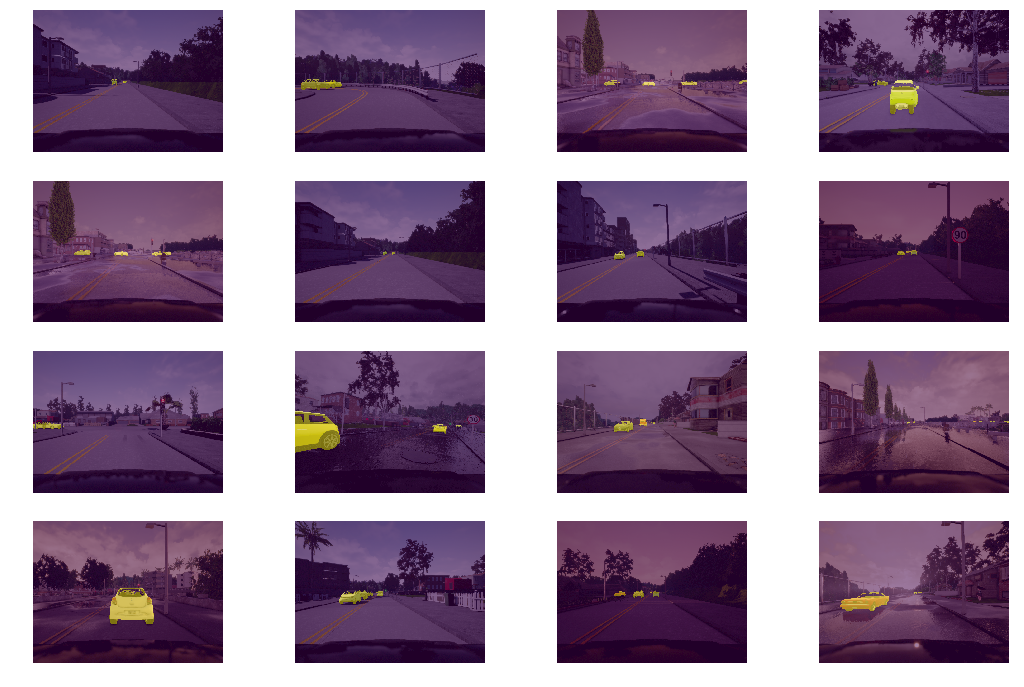

In [16]:
fig, axes = plt.subplots(4,4, figsize=(18,12))
for i, ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(masks[i][...,0], ax=ax, alpha=0.5)

In [17]:
class MatchedFilesDatset(FilesDataset):
    def __init__(self, filenames, y, transform, path):
        assert(len(filenames == len(y)))
        self.y = y
        super().__init__(filenames, transform, path)
        
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    
    def get_c(self): return 0

In [18]:
x_names = np.array(list((PATH/TRAIN_DN).iterdir()))
y_names = np.array(list((PATH/MASKS_DN).iterdir()))

len(x_names), len(y_names)

(2000, 2000)

In [21]:
# val_idxs = list(range(len(x_names)//5)) # 20% validation split
val_idxs = list(range(0,len(x_names),5)) # better 20% validation split
((val_x, trn_x),(val_y, trn_y)) = split_by_idx(val_idxs, x_names, y_names) # split the in/out pairs the same

In [22]:
len(val_x), len(trn_x), trn_x[0], trn_y[0]

(400,
 1600,
 PosixPath('data/lyft/train/88.png'),
 PosixPath('data/lyft/car_masks/88.png'))

In [23]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]

In [24]:
transforms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDatset, (trn_x,trn_y), (val_x,val_y), transforms, path='')
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [21]:
# Use this cell to print the denormed image for visualization purposes
# denorm = md.trn_ds.denorm
# x,y = next(iter(md.aug_dl))
# x = denorm(x)

In [23]:
# This cell is for educational purposes, to see inside the resnet arch

# class Empty(nn.Module): 
#     def forward(self,x): return x

# models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
# learn = ConvLearner(md, models)
# learn.summary()

In [25]:
from lyft_helpers import *

In [26]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

 92%|█████████▏| 23/25 [00:18<00:01,  1.26it/s, loss=5.94] 

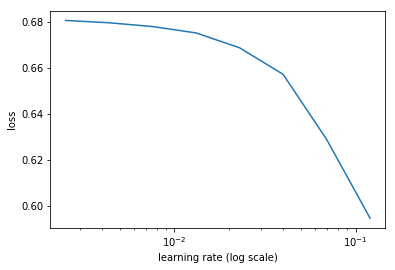

In [27]:
learn.lr_find()
learn.sched.plot()

In [28]:
lr=4e-2

In [29]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.249632   11.46826   0.472482  
    1      0.127112   0.135151   0.959995                  
    2      0.079188   0.028585   0.990318                   
    3      0.055867   0.026014   0.990873                   
    4      0.043104   0.024676   0.991381                   


[array([0.02468]), 0.9913807678222656]

In [31]:
learn.save('tmp')

In [30]:
# torch.save(learn.model, 'car-fullmodel-2.pt')

In [32]:
learn.load('tmp')

In [33]:
# py,ay = learn.predict_with_targs()

In [34]:
# ay.shape

In [32]:
# show_img(ay[5]);

In [35]:
# show_img(py[5]>0);

In [33]:
learn.unfreeze()

In [34]:
learn.bn_freeze(True)

In [35]:
lrs = np.array([lr/100, lr/10, lr])/4

In [36]:
learn.fit(lrs, 1, cycle_len=20, use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.052741   0.026397   0.990723  
    1      0.03643    0.021171   0.9921                     
    2      0.028773   0.018879   0.993402                   
    3      0.023805   0.016102   0.993516                   
    4      0.020178   0.014335   0.994548                   
    5      0.017701   0.013633   0.994348                   
    6      0.016015   0.012375   0.994858                   
    7      0.014648   0.011989   0.995228                   
    8      0.013714   0.011599   0.99526                    
    9      0.012984   0.011087   0.995408                   
    10     0.01228    0.010438   0.99547                    
    11     0.011726   0.010201   0.995581                   
    12     0.011311   0.01007    0.995558                   
    13     0.010944   0.009809   0.995747                   
    14     0.010628   0.009739   0.995676                   
    15     0.010364   0.009549   0.995868

[array([0.00902]), 0.9960554504394531]

In [37]:
# torch.save(learn.model, 'car-fullmodel-2.pt')

In [41]:
# py,ay = learn.predict_with_targs()

In [42]:
# show_img(ay[5]);

In [43]:
# show_img(py[5]>0);

In [38]:
learn.save('car-128')

In [45]:
# torch.save(learn.model, 'car-fullmodel.pt')
# torch.save(learn.model.state_dict(), 'road-weights.pt')

# Time to try a larger image size

In [39]:
sz = 512
bs = 16

In [40]:
transforms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDatset, (trn_x,trn_y), (val_x,val_y), transforms, path='')
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [41]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [42]:
learn.load('car-128')

 81%|████████  | 81/100 [01:52<00:26,  1.39s/it, loss=1.1]   

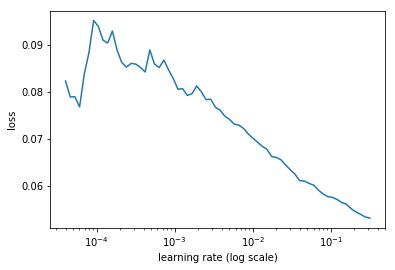

In [43]:
learn.lr_find()
learn.sched.plot()

In [44]:
lr=4e-2
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                     
    0      0.022819   0.015792   0.994703  
    1      0.01526    0.012223   0.995358                     
    2      0.012848   0.010901   0.996                        
    3      0.011663   0.010148   0.99578                      
    4      0.010497   0.0097     0.996177                    


[array([0.0097]), 0.996176700592041]

In [45]:
learn.save('car-512')

In [46]:
learn.load('car-512')

In [47]:
learn.unfreeze()
learn.bn_freeze(True)

In [48]:
torch.save(learn.model, 'car-fullmodel-2kds-1.pt')

In [49]:
lrs = np.array([lr/100,lr/10,lr])/4

In [50]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>                     
    0      0.066294   0.068271   0.988041  
    1      0.064104   0.056291   0.988229                     
    2      0.030283   0.018375   0.99371                      
    3      0.015679   0.010751   0.995385                     
    4      0.011853   0.009279   0.995884                     
    5      0.009289   0.008203   0.996392                      
    6      0.008479   0.007338   0.996614                      
    7      0.007776   0.007089   0.996679                     


[array([0.00709]), 0.9966787242889404]

In [51]:
learn.save('car-512-2')

In [52]:
# learn.load('car-128')
torch.save(learn.model, 'car-fullmodel-2kds-2.pt')

In [60]:
# py,ay = learn.predict_with_targs()

In [61]:
# show_img(ay[5]);

In [62]:
# show_img(py[5]>0);

In [63]:
# py[5]